In [1]:
import os
import json
import numpy as np

from qdrant_client import QdrantClient

In [50]:
# Qdrant
QDRANT_URL = "http://192.168.0.12:6333"
QDRANT_API_KEY = None

COLLECTION = "faces_with_thumbs"
LIMIT = None          # None = все
BATCH = 512

# Поля путей в payload
THUMB_FIELD = "thumb"
FULL_FIELD  = "full"

# Лейбл
DEFAULT_LABEL = "faces"
LABEL_FIELD = None    # например "label"

# 2D проекция: "umap" или "tsne"
PROJECT_METHOD = "tsne"
SEED = 42

# Параметры t-SNE (можно менять)
TSNE_PERPLEXITY = 30
TSNE_LEARNING_RATE = "auto"   # или число, напр. 200
TSNE_ITER = 1000              # число итераций

# Выходной файл
OUT_TS = "src/data/demoPoints.ts"

In [ ]:
def normalize_web_path(p: str) -> str:
    p = (p or "").replace("\\", "/")
    if not p.startswith("/"):
        p = "/" + p.lstrip("./")
    return p

def safe_float(v, ndigits=3) -> float:
    try:
        return float(np.round(float(v), ndigits))
    except Exception:
        return 0.0

def build_id(payload, point_id, full_path_web: str) -> str:
    if isinstance(payload.get("id"), str) and payload["id"]:
        return payload["id"]
    if full_path_web:
        base = os.path.basename(full_path_web.replace("\\", "/"))
        name, _ = os.path.splitext(base)
        if name:
            return name
    return str(point_id)

def guess_label(payload, default_label="faces") -> str:
    kind = payload.get("kind")
    if kind == "photo":
        return "photos"
    if kind == "face":
        return "faces"
    return default_label

def project_2d(vectors: np.ndarray, method="umap", seed=42):
    method = method.lower()
    if vectors.shape[0] == 0:
        return np.zeros((0, 2), dtype=np.float32)

    if method == "umap":
        import umap  # type: ignore
        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=50,
            min_dist=0.5,
            metric="cosine",
            spread=0.7,
            random_state=seed,
        )
        xy = reducer.fit_transform(vectors)
        return xy.astype(np.float32)

    if method == "tsne":
        from sklearn.manifold import TSNE  # type: ignore
        # t-SNE тяжёлый: иногда полезно сначала сделать PCA до 50 измерений, но оставим по-простому
        tsne = TSNE(
            n_components=2,
            random_state=seed,
            perplexity=TSNE_PERPLEXITY,
            learning_rate=TSNE_LEARNING_RATE,
            early_exaggeration=4.0,
            init="pca",
            metric="cosine",
        )
        xy = tsne.fit_transform(vectors)
        return xy.astype(np.float32)

    raise ValueError("PROJECT_METHOD должен быть 'umap' или 'tsne'")

def render_ts(points):
    header = (
        'import type { DemoPoint } from "../types";\n\n'
        'export const LABELS = ["faces", "photos"] as const;\n\n'
        "export const DEMO_POINTS: DemoPoint[] = [\n"
    )
    body = []
    for p in points:
        body.append(
            "    " + json.dumps(p, ensure_ascii=False, indent=4).replace("\n", "\n    ").rstrip() + ","
        )
    footer = "\n];\n"
    return header + "\n".join(body) + footer

In [31]:
client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY, prefer_grpc=False)
client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='faces'), CollectionDescription(name='faces_with_thumbs')])

In [32]:
ids = []
vectors_list = []
payloads = []

offset = None
fetched = 0

while True:
    limit = BATCH
    if LIMIT is not None:
        remaining = LIMIT - fetched
        if remaining <= 0:
            break
        limit = min(limit, remaining)

    points, next_page = client.scroll(
        collection_name=COLLECTION,
        limit=limit,
        offset=offset,
        with_vectors=True,
        with_payload=True,
    )

    if not points:
        break

    for p in points:
        vec = None
        if isinstance(p.vector, list):
            vec = p.vector
        elif isinstance(p.vector, dict):
            vec = next(iter(p.vector.values()))
        if vec is None:
            continue

        ids.append(p.id)
        vectors_list.append(vec)
        payloads.append(p.payload or {})

    fetched += len(points)
    offset = next_page
    if offset is None:
        break

len(vectors_list), len(payloads)

(761, 761)

In [53]:
vectors = np.asarray(vectors_list, dtype=np.float32)
# xy = project_2d(vectors, method=PROJECT_METHOD, seed=SEED)
xy = project_2d(vectors, method="umap", seed=SEED)

xy.shape

c:\Users\nike1\projects\photo_clustering\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(761, 2)

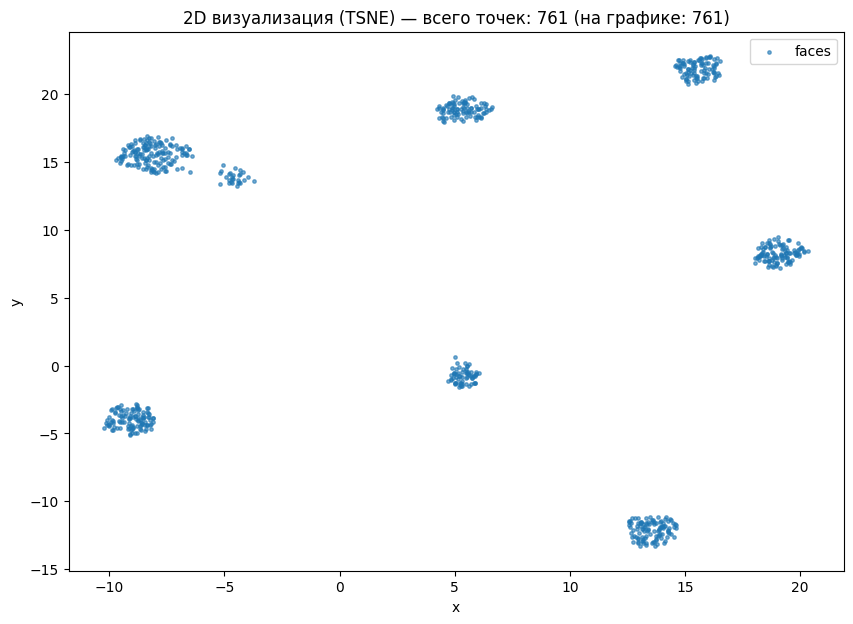

In [55]:
import matplotlib.pyplot as plt

# Цветим по label (если LABEL_FIELD задан — используем его, иначе guess_label)
labels_for_plot = []
for payload in payloads:
    payload = payload or {}
    if LABEL_FIELD:
        lab = str(payload.get(LABEL_FIELD, DEFAULT_LABEL))
        if lab not in ("faces", "photos"):
            lab = DEFAULT_LABEL
    else:
        lab = guess_label(payload, default_label=DEFAULT_LABEL)
    labels_for_plot.append(lab)

labels_for_plot = np.array(labels_for_plot)

# Можно ограничить число точек на графике, если их очень много
MAX_PLOT = 20000
if xy.shape[0] > MAX_PLOT:
    idx = np.random.RandomState(SEED).choice(xy.shape[0], size=MAX_PLOT, replace=False)
else:
    idx = np.arange(xy.shape[0])

plt.figure(figsize=(10, 7))
for lab in ["faces", "photos"]:
    mask = (labels_for_plot[idx] == lab)
    if np.any(mask):
        plt.scatter(xy[idx][mask, 0], xy[idx][mask, 1], s=6, alpha=0.6, label=lab)

plt.title(f"2D визуализация ({PROJECT_METHOD.upper()}) — всего точек: {xy.shape[0]} (на графике: {len(idx)})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [48]:
out_points = []

for i, payload in enumerate(payloads):
    payload = payload or {}

    thumb = normalize_web_path(str(payload.get(THUMB_FIELD, "")))
    full  = normalize_web_path(str(payload.get(FULL_FIELD, payload.get("photo_path", ""))))

    if LABEL_FIELD:
        label = str(payload.get(LABEL_FIELD, DEFAULT_LABEL))
        if label not in ("faces", "photos"):
            label = DEFAULT_LABEL
    else:
        label = guess_label(payload, default_label=DEFAULT_LABEL)

    pid = build_id(payload, ids[i], full)

    out_points.append({
        "id": pid,
        "x": safe_float(xy[i, 0], 3),
        "y": safe_float(xy[i, 1], 3),
        "label": label,
        "thumb": thumb,
        "full": full,
    })

out_points[:2], len(out_points)

([{'id': 'DSC_0106',
   'x': 2.737,
   'y': -7.902,
   'label': 'faces',
   'thumb': '/thumbs/DSC_0106_0.jpg',
   'full': '/photos/DSC_0106.JPG'},
  {'id': 'DSC_0110',
   'x': 3.436,
   'y': -7.705,
   'label': 'faces',
   'thumb': '/thumbs/DSC_0110_0.jpg',
   'full': '/photos/DSC_0110.JPG'}],
 761)

In [51]:
ts_text = render_ts(out_points)

with open(OUT_TS, "w", encoding="utf-8") as f:
    f.write(ts_text)

OUT_TS

'src/data/demoPoints.ts'

In [23]:
print("\n".join(ts_text.splitlines()[:40]))

import type { DemoPoint } from "../types";

export const LABELS = ["faces", "photos"] as const;

export const DEMO_POINTS: DemoPoint[] = [
    {
        "id": "DSC_0106",
        "x": 13.006,
        "y": -8.161,
        "label": "faces",
        "thumb": "/thumbs/DSC_0106_0.jpg",
        "full": "/photos/DSC_0106.JPG"
    },
    {
        "id": "DSC_0110",
        "x": 13.306,
        "y": -7.984,
        "label": "faces",
        "thumb": "/thumbs/DSC_0110_0.jpg",
        "full": "/photos/DSC_0110.JPG"
    },
    {
        "id": "DSC_0110",
        "x": 23.304,
        "y": 3.828,
        "label": "faces",
        "thumb": "/thumbs/DSC_0110_1.jpg",
        "full": "/photos/DSC_0110.JPG"
    },
    {
        "id": "DSC_0110",
        "x": 7.906,
        "y": 8.145,
        "label": "faces",
        "thumb": "/thumbs/DSC_0110_2.jpg",
        "full": "/photos/DSC_0110.JPG"
    },
    {
        "id": "DSC_0110",
        "x": 3.056,
